<a href="https://colab.research.google.com/github/advaithgit/dataaces_workadvaith/blob/main/Day11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd

df = pd.read_excel('News.xlsx')
content_column = df['content']


In [4]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

vader_scores = []

for content in content_column:
    sentiment = sia.polarity_scores(content)
    vader_scores.append(sentiment)

vader_df = pd.DataFrame(vader_scores)

df = pd.concat([df, vader_df], axis=1)


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [2]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 47.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.3 MB/s eta 0:00:00


In [5]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)


In [6]:
roberta_scores = []

for content in content_column:
    inputs = tokenizer(content, return_tensors="pt", truncation=True, padding=True, max_length=512)
    output = model(**inputs)
    scores = output.logits
    scores = softmax(scores.detach().numpy(), axis=1)

    scores_dict = {
        'roberta_neg': scores[0][0].item(),
        'roberta_neu': scores[0][1].item(),
        'roberta_pos': scores[0][2].item()
    }
    roberta_scores.append(scores_dict)

roberta_df = pd.DataFrame(roberta_scores)

df = pd.concat([df, roberta_df], axis=1)


In [7]:
from transformers import pipeline
import pandas as pd


sent_pipeline = pipeline("sentiment-analysis")

sentiment_predictions = []

for content in df['content']:
    max_chunk_length = 512
    content_chunks = [content[i:i+max_chunk_length] for i in range(0, len(content), max_chunk_length)]

    chunk_sentiments = []

    for chunk in content_chunks:
        sentiment = sent_pipeline(chunk)
        chunk_sentiments.append(sentiment[0])

    combined_sentiment = {"label": max(chunk_sentiments, key=lambda x: x['score'])['label']}
    sentiment_predictions.append(combined_sentiment)

sentiment_df = pd.DataFrame(sentiment_predictions)

df = pd.concat([df, sentiment_df], axis=1)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [8]:
df.to_excel('sentiment_analysis_results.xlsx', index=False)


In [9]:
df['RoBERTa_Compound'] = 0.5 * (df['roberta_pos'] + df['roberta_neu']) - 0.5 * df['roberta_neg']

df.to_excel('sentiment_analysis_results_with_compound.xlsx', index=False)


In [10]:
label_to_compound = {
    "NEGATIVE": -1,
    "NEUTRAL": 0,
    "POSITIVE": 1
}

df['Hugging_FACE_Compound'] = df['label'].map(label_to_compound)

df.to_excel('sentiment_analysis_results_with_compound.xlsx', index=False)


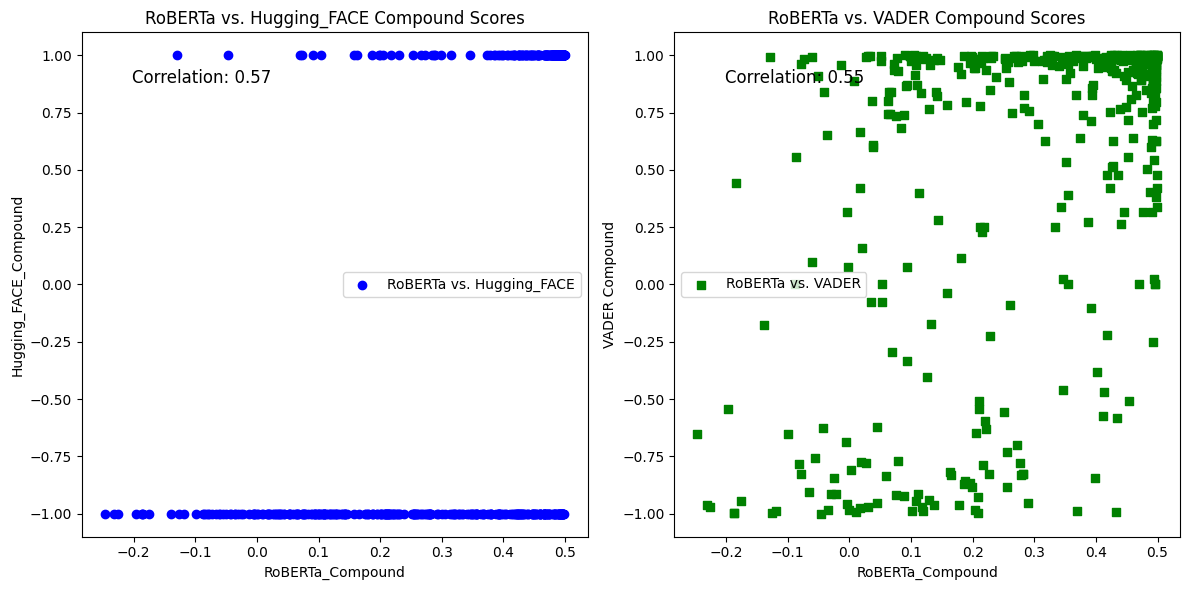

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats


plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.scatter(df['RoBERTa_Compound'], df['Hugging_FACE_Compound'], c='b', marker='o', label='RoBERTa vs. Hugging_FACE')
plt.xlabel('RoBERTa_Compound')
plt.ylabel('Hugging_FACE_Compound')
plt.title('RoBERTa vs. Hugging_FACE Compound Scores')
plt.legend()

plt.subplot(122)
plt.scatter(df['RoBERTa_Compound'], df['compound'], c='g', marker='s', label='RoBERTa vs. VADER')
plt.xlabel('RoBERTa_Compound')
plt.ylabel('VADER Compound')
plt.title('RoBERTa vs. VADER Compound Scores')
plt.legend()

corr_coefficient_hugging_face = np.corrcoef(df['RoBERTa_Compound'], df['Hugging_FACE_Compound'])[0, 1]
corr_coefficient_vader = np.corrcoef(df['RoBERTa_Compound'], df['compound'])[0, 1]

plt.subplot(121)
plt.text(0.1, 0.9, f'Correlation: {corr_coefficient_hugging_face:.2f}', transform=plt.gca().transAxes, fontsize=12)
plt.subplot(122)
plt.text(0.1, 0.9, f'Correlation: {corr_coefficient_vader:.2f}', transform=plt.gca().transAxes, fontsize=12)

plt.tight_layout()
plt.show()


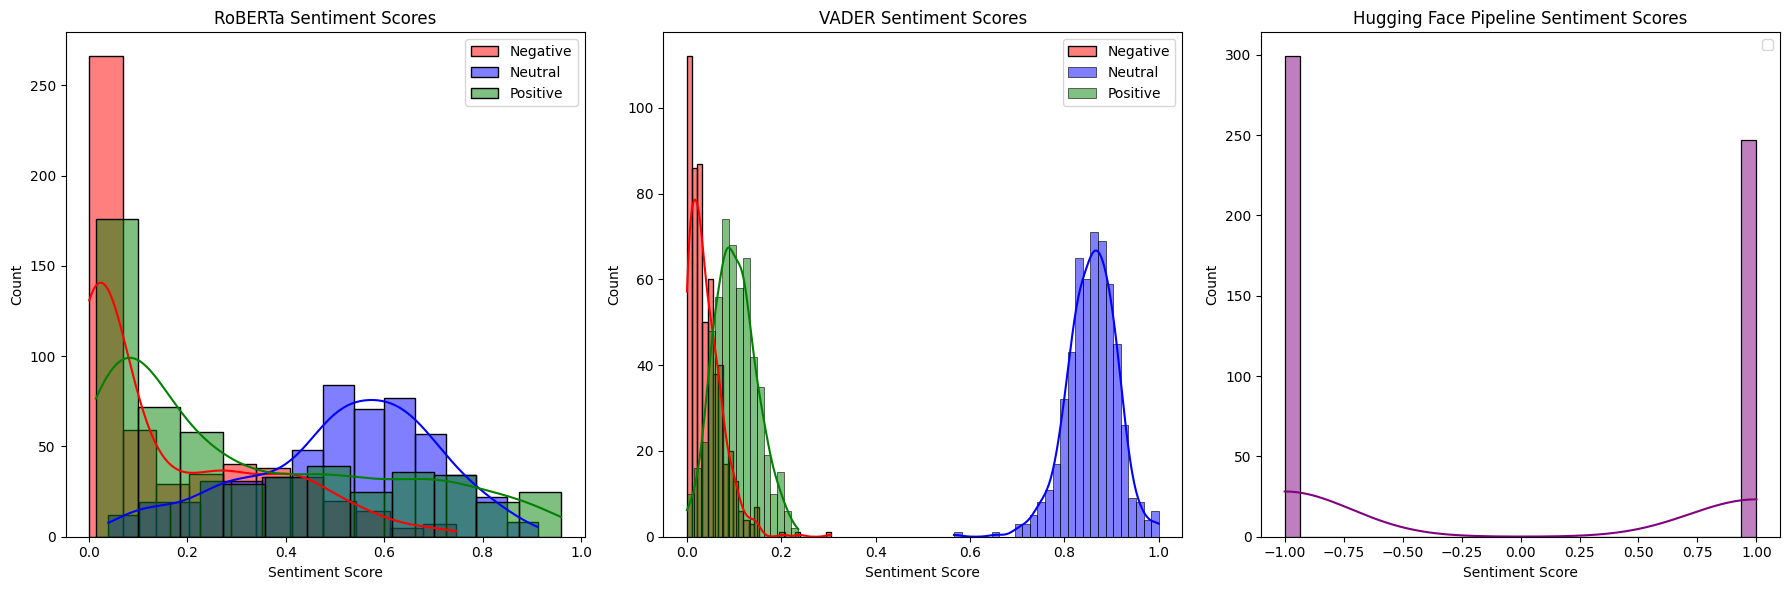

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.histplot(data=df, x='roberta_neg', color='red', label='Negative', ax=axes[0], kde=True)
sns.histplot(data=df, x='roberta_neu', color='blue', label='Neutral', ax=axes[0], kde=True)
sns.histplot(data=df, x='roberta_pos', color='green', label='Positive', ax=axes[0], kde=True)
axes[0].set_title('RoBERTa Sentiment Scores')
axes[0].legend()

sns.histplot(data=df, x='neg', color='red', label='Negative', ax=axes[1], kde=True)
sns.histplot(data=df, x='neu', color='blue', label='Neutral', ax=axes[1], kde=True)
sns.histplot(data=df, x='pos', color='green', label='Positive', ax=axes[1], kde=True)
axes[1].set_title('VADER Sentiment Scores')
axes[1].legend()

sns.histplot(data=df, x='Hugging_FACE_Compound', color='purple', bins=30, ax=axes[2], kde=True)
axes[2].set_title('Hugging Face Pipeline Sentiment Scores')
axes[2].legend()

for ax in axes:
    ax.set_xlabel('Sentiment Score')

plt.tight_layout()

plt.show()
